In [5]:
import numpy as np
import torch
from torch import nn, optim, tensor
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_train_data = mnist_trainset.data.numpy()
Y_train_data = mnist_trainset.targets.numpy()
X_test_data = mnist_testset.data.numpy()
Y_test_data = mnist_testset.targets.numpy()

def calc_vec_from_digit(digit):
    vec = np.zeros(10)
    vec[digit] = 1.0
    return vec

def calc_digit_from_vec(vec):
    result = -1
    for i in range(vec.shape[0]):
        if (vec[i] == 1.0):
            result = i
            
    if (result >= 0):
        return result

X_train = np.zeros(shape = (X_train_data.shape[0], X_train_data.shape[1] * X_train_data.shape[2]))
for i in range(X_train.shape[0]):
    X_train[i] = X_train_data[i].flatten()
X_test = np.zeros(shape = (X_test_data.shape[0], X_test_data.shape[1] * X_test_data.shape[2]))
for i in range(X_test.shape[0]):
    X_test[i] = X_test_data[i].flatten()
Y_train = np.zeros(shape = (Y_train_data.shape[0], 10))
for i in range(Y_train.shape[0]):
    Y_train[i] = calc_vec_from_digit(Y_train_data[i]) 
Y_test = np.zeros(shape = (Y_test_data.shape[0], 10))
for i in range(Y_test.shape[0]):
    Y_test[i] = calc_vec_from_digit(Y_test_data[i])

In [2]:
#Use slightly modified sigmoid to prevent overflow
def calc_sigmoid(z):
    max_val = np.max(z)
    min_val = np.min(z)
    if (max_val > 10000):
        return (1 / (1 + np.exp(-z)))
    elif (min_val < -10000):
        return (np.exp(z) / (1 + np.exp(z)))
    else: 
        return (1 / (1 + np.exp(-z)))

def calc_sigmoid_derivative(z):
    sigmoid = calc_sigmoid(z)
    return (sigmoid) * (1 - sigmoid)

def calc_softmax(vec):
    sum_exp = np.sum(np.exp(vec))
    for i in range(vec.shape[0]):
        vec[i] = np.exp(vec[i]) / sum_exp
        
    return vec

class NeuralNetwork:
    def __init__(self, train_data, hidden_layer_size, learning_rate, batch_size, max_iters, randomize_weights):
        self.X_train = train_data[0]
        self.Y_train = train_data[1]
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iters = max_iters
        if (randomize_weights):
            self.W1 = np.random.uniform(-1, 1, (self.hidden_layer_size, self.X_train.shape[1]))
            self.W2 = np.random.uniform(-1, 1, (self.Y_train.shape[1], self.hidden_layer_size))
        else:
            self.W1 = np.zeros(shape=(self.hidden_layer_size, self.X_train.shape[1]))
            self.W2 = np.zeros(shape=(self.Y_train.shape[1], self.hidden_layer_size))
        self.accuracy_plot_data = []
        self.iters_plot_data = []
        
    def get_batch(self):
        index = np.random.choice(self.X_train.shape[0], self.batch_size, replace=False)
        return (X_train[index], Y_train[index])
        
    def predict(self, sample):
        return calc_softmax(((self.W2).dot(calc_sigmoid((self.W1).dot(sample)))))
    
    def get_y_predict(self, X):
        y_predict = np.zeros(shape = (X.shape[0], 10))
        for i in range(X.shape[0]):
            y_predict[i] = self.predict(X[i])
            
        return y_predict
        
    def calc_loss(self, y_predict, y_true):
        return -np.sum(y_true * np.log(y_predict))
    
    def calc_accuracy(self, X_test, Y_test):
        num_correct = 0
        total = 0
        for i in range(X_test.shape[0]):
            total += 1
            prediction = self.predict(X_test[i])
            if (np.argmax(prediction) == calc_digit_from_vec(Y_test[i])):
                num_correct += 1
        
        return num_correct / total
    
    
    def compute_gradients(self, X, Y):
        #First, need to compute prediction with current weights
        y_predict = self.get_y_predict(X)
        
        #Store some variables so they aren't calculated more than once
        d_Y = y_predict - Y
        W1_X = (self.W1).dot(np.transpose(X))
        
        #Compute and return gradients
        d_W1 = np.transpose((np.transpose(X)).dot(np.multiply((d_Y.dot(self.W2)), np.transpose(calc_sigmoid_derivative(W1_X)))))
        d_W2 = np.transpose((calc_sigmoid(W1_X)).dot(d_Y))
        
        return (d_W1, d_W2)
    
    def train(self):
        for i in range(self.max_iters):
            (batch_X, batch_Y) = self.get_batch()
            gradients = self.compute_gradients(batch_X, batch_Y)
            self.W1 = self.W1 - (self.learning_rate * gradients[0])
            self.W2 = self.W2 - (self.learning_rate * gradients[1])
            #accuracy = self.calc_accuracy(X_test, Y_test)
            #self.accuracy_plot_data.append(self.calc_accuracy(X_test, Y_test))
            if ((i+1) % 500 == 0):
                accuracy = self.calc_accuracy(X_test, Y_test)
                self.accuracy_plot_data.append(accuracy)
                self.iters_plot_data.append(i+1)
                print("Iteration " + str(i+1) + ": Accuracy = " + str(accuracy))

            
nn = NeuralNetwork((X_train, Y_train), 300, 0.0005, 32, 10000, True)
nn.train()

nn2 = NeuralNetwork((X_train, Y_train), 300, 0.0005, 32, 10000, False)
nn2.train()

/var/folders/ng/tyw_c8dx1ss0kny35zj2qnkm0000gn/T/ipykernel_85781/1983693774.py:10: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-z)))


Iteration 500: Accuracy = 0.5241
Iteration 1000: Accuracy = 0.6544
Iteration 1500: Accuracy = 0.7119
Iteration 2000: Accuracy = 0.7413
Iteration 2500: Accuracy = 0.7563
Iteration 3000: Accuracy = 0.7783
Iteration 3500: Accuracy = 0.7966
Iteration 4000: Accuracy = 0.8083
Iteration 4500: Accuracy = 0.8185
Iteration 5000: Accuracy = 0.8214
Iteration 5500: Accuracy = 0.8287
Iteration 6000: Accuracy = 0.8319
Iteration 6500: Accuracy = 0.8396
Iteration 7000: Accuracy = 0.8362
Iteration 7500: Accuracy = 0.8372
Iteration 8000: Accuracy = 0.8389
Iteration 8500: Accuracy = 0.8493
Iteration 9000: Accuracy = 0.8494
Iteration 9500: Accuracy = 0.8492
Iteration 10000: Accuracy = 0.8533
Iteration 500: Accuracy = 0.1042
Iteration 1000: Accuracy = 0.1143
Iteration 1500: Accuracy = 0.1124
Iteration 2000: Accuracy = 0.1314
Iteration 2500: Accuracy = 0.1128
Iteration 3000: Accuracy = 0.1215
Iteration 3500: Accuracy = 0.1177
Iteration 4000: Accuracy = 0.133
Iteration 4500: Accuracy = 0.1271
Iteration 5000: 

Text(0, 0.5, 'Accuracy')

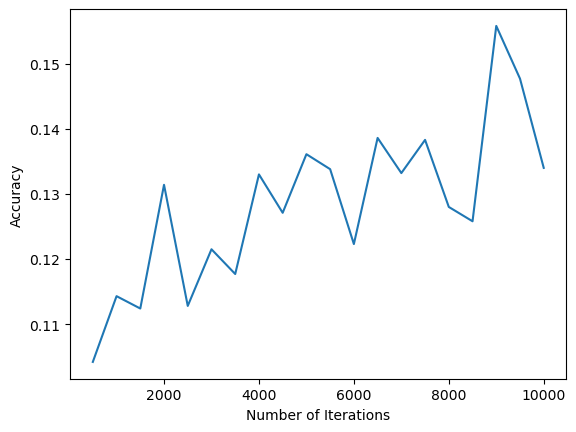

In [3]:
plt.plot(nn2.iters_plot_data, nn2.accuracy_plot_data)
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

In [9]:
model = nn.Sequential(nn.Linear(784, 300), 
                      nn.Sigmoid(),
                      nn.Linear(300, 10),
                      nn.LogSoftmax(dim=1))

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=1)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
batch_size = 32

iters = []
accuracy_data = []

def calc_accuracy(output):
    num_total = output.shape[0]
    num_correct = 0
    for i in range(num_total):
        prediction = torch.argmax(output[i]).item()
        if (prediction == Y_test_data[i]):
            num_correct += 1
            
    return (num_correct / num_total)

#Acknowledgement: I mostly followed the implementation here: https://www.kaggle.com/code/riteshsinha/neural-networks-with-pytorch-mnist
for i in range((X_train.shape[0]-1)//batch_size + 1):
        iters.append(i)
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = X_train[start_i:end_i]
        yb = Y_train[start_i:end_i]
        pred = model(xb)
        accuracy_data.append(calc_accuracy(pred))
        loss = loss_func(pred, yb)
        loss.backward()
        optimizer.step() # Updating weights.
        optimizer.zero_grad()

print("Accuracy: " + str(calc_accuracy(model(X_test))))  

plt.plot(iters, accuracy_data)
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

/var/folders/ng/tyw_c8dx1ss0kny35zj2qnkm0000gn/T/ipykernel_85781/85703503.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/ng/tyw_c8dx1ss0kny35zj2qnkm0000gn/T/ipykernel_85781/85703503.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/ng/tyw_c8dx1ss0kny35zj2qnkm0000gn/T/ipykernel_85781/85703503.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/var/fo

Accuracy: 0.8834


Text(0, 0.5, 'Accuracy')